## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [136]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

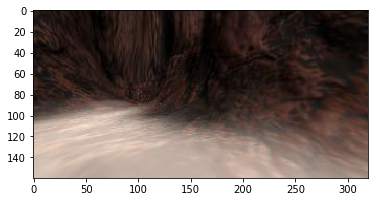

In [3]:
path = '../generated_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

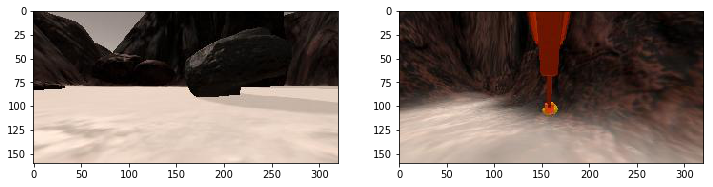

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock3.jpg'
example_rock_pick_upable = '../calibration_images/example_rock_pick_upable.jpg'
example_obstacle = '../calibration_images/example_obsticle1.jpg'
example_overhang = '../calibration_images/example_overhang1.jpg'
example_pickingup = '../calibration_images/example_pickingup1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)
obstacle_img = mpimg.imread(example_obstacle)
overhang_img = mpimg.imread(example_overhang)
pick_upable_rock_img = mpimg.imread(example_rock_pick_upable)
pickingup_img = mpimg.imread(example_pickingup)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(overhang_img)
plt.subplot(122)
plt.imshow(pickingup_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

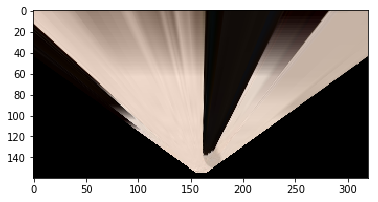

In [5]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(overhang_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

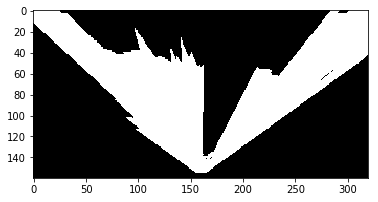

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
#     isInRange = (img[:,:,0] > rgb_thresh[0]) & (img[:,:,1] > rgb_thresh[1]) & (img[:,:,2] > rgb_thresh[2]) \
#                 & (img[:,:,0] < 220) & (img[:,:,1] < 180) & (img[:,:,2] < 90)
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

160 63


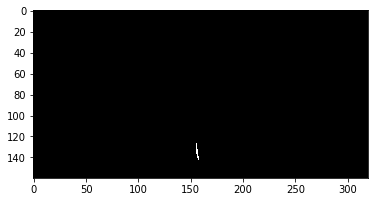

In [7]:
# Identify pixels in range.
# Threshold of 120 < R < 220, 100 < G < 180 and -1 < B < 90 does a nice job of identifying rock samples
def color_range(img, rgb_thresh_bottom=(125, 100, -1), rgb_thresh_top=(200, 180, 90)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Requires that each pixel be in between the range for all three threshold values of RGB.
    # in_range will now contain a boolean array with 'True' where the values are in range given.
    in_range = (img[:,:,0] > rgb_thresh_bottom[0]) & (img[:,:,0] < rgb_thresh_top[0]) \
            & (img[:,:,1] > rgb_thresh_bottom[1]) & (img[:,:,1] < rgb_thresh_top[1]) \
            & (img[:,:,2] > rgb_thresh_bottom[2]) & (img[:,:,2] < rgb_thresh_top[2])
    
    # Index the arry of zeros with the boolean array and set to 1
    color_select[in_range] = 1
    print(len(in_range), np.count_nonzero(in_range))
    
    
    # Return the binary image
    return color_select


rock_threshed = color_range(rock_img)
warped = perspect_transform(rock_threshed, source, destination)
plt.imshow(warped, cmap='gray')

160 1442


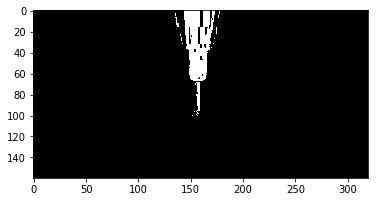

In [52]:
# Identify pixels in range.
# Threshold of 120 < R < 220, 100 < G < 180 and -1 < B < 90 does a nice job of identifying rock samples
def color_range(img, rgb_thresh_bottom=(85, 10, -1), rgb_thresh_top=(125, 30, 5)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Requires that each pixel be in between the range for all three threshold values of RGB.
    # in_range will now contain a boolean array with 'True' where the values are in range given.
    in_range = (img[:,:,0] > rgb_thresh_bottom[0]) & (img[:,:,0] < rgb_thresh_top[0]) \
            & (img[:,:,1] > rgb_thresh_bottom[1]) & (img[:,:,1] < rgb_thresh_top[1]) \
            & (img[:,:,2] > rgb_thresh_bottom[2]) & (img[:,:,2] < rgb_thresh_top[2])
    
    # Index the arry of zeros with the boolean array and set to 1
    color_select[in_range] = 1
    print(len(in_range), np.count_nonzero(in_range))
    
    
    # Return the binary image
    return color_select

threshed = color_range(pickingup_img)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

-0.261799387799
-0.463647609001
160 61
(160, 320) (160, 320, 3)
0
0
nan


C:\Users\Santosh\Miniconda3\envs\RoboND\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Santosh\Miniconda3\envs\RoboND\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


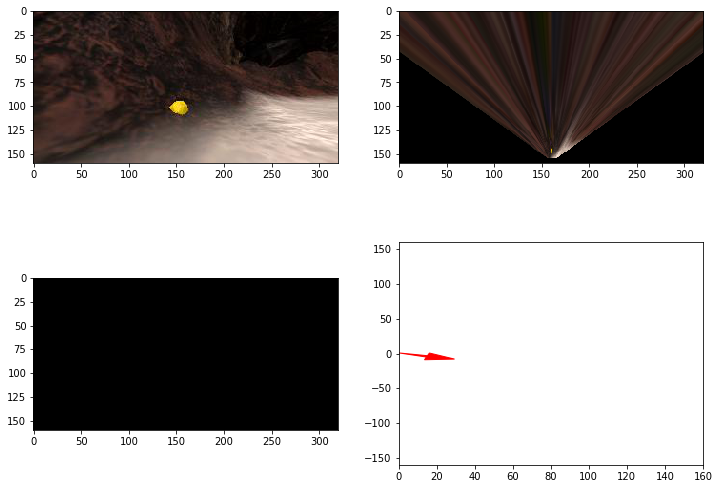

In [26]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    # Apply a rotation
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    ypix_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
# idx = np.random.randint(0, len(img_list)-1)
# image = mpimg.imread(img_list[idx])
image = pick_upable_rock_img
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)

dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)
# np.clip(np.max(angles * 180/np.pi) - 10, -15, 15)
clip_angle = 15 * (np.pi / 180)
max_dir = np.clip(np.max(angles) - (13 * np.pi / 180), -clip_angle, clip_angle)
print(max_dir) 
print(np.max(angles))

rock_threshed = color_range(image)
rock_threshed = perspect_transform(rock_threshed, source, destination)
rock_threshed[:, (int)(rock_threshed.shape[1] / 2)] = 0
rock_xpix, rock_ypix = rover_coords(rock_threshed)
print(rock_threshed.shape, image.shape)
rock_distances, rock_angles  = to_polar_coords(rock_xpix, rock_ypix)
is_near_rock = len(rock_distances) and np.mean(rock_distances) < 13
print(is_near_rock)
print(len(rock_distances))
print(np.mean(rock_distances))

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(rock_threshed, cmap='gray')
plt.subplot(224)
plt.plot(rock_xpix, rock_ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = np.mean(dist)
x_arrow = arrow_length * np.cos(max_dir)
y_arrow = arrow_length * np.sin(max_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [143]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../generated_dataset/robot_log.csv', delimiter=',', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [227]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # 1) Define source and destination points for perspective transform
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
                  [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                  ])
    # 2) Apply perspective transform
    warped = perspect_transform(img, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed = color_thresh(warped)
    rock_threshed = color_range(warped)
    obsticle_threshed = ~threshed
    # 4) Convert thresholded image pixel values to rover-centric coords
    navigable_xpix, navigable_ypix = rover_coords(threshed)
    rock_xpix, rock_ypix = rover_coords(rock_threshed)
    obsticle_xpix, obsticle_ypix = rover_coords(obsticle_threshed)
    
    # 5) Convert rover-centric pixel values to world coords
    scale = 10
    navigable_xpix_world, navigable_ypix_world = pix_to_world(navigable_xpix, \
                                                              navigable_ypix, \
                                                              data.xpos[data.count], \
                                                              data.ypos[data.count], \
                                                              data.yaw[data.count], \
                                                              data.worldmap.shape[0], \
                                                              scale)
    rock_xpix_world, rock_ypix_world = pix_to_world(rock_xpix, \
                                                    rock_ypix, \
                                                    data.xpos[data.count], \
                                                    data.ypos[data.count], \
                                                    data.yaw[data.count], \
                                                    data.worldmap.shape[0], \
                                                    scale)
    obsticle_xpix_world, obsticle_ypix_world = pix_to_world(obsticle_xpix, \
                                                            obsticle_ypix, \
                                                            data.xpos[data.count], \
                                                            data.ypos[data.count], \
                                                            data.yaw[data.count], \
                                                            data.worldmap.shape[0], \
                                                            scale)
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    data.worldmap[navigable_ypix_world, navigable_xpix_world, 2] += 1
    data.worldmap[rock_ypix_world, rock_xpix_world, 1] += 1
    data.worldmap[navigable_ypix_world, navigable_xpix_world, 0] -= 1
    data.worldmap[obsticle_ypix_world, obsticle_xpix_world, 0] += 1
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [157]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

109.2312 163.6855 242.4221
[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


  0%|                                                                                         | 0/2466 [00:00<?, ?it/s]

99.66999 85.58897 56.80604
99.66999 85.58897 56.80604
99.66999 85.58897 56.80604
99.66999 85.58897 56.80604
99.66999 85.58897 56.80604
99.66999 85.58897 56.80604
99.66999 85.58897 56.89357
99.66999 85.58897 57.20386


  0%|▎                                                                                | 8/2466 [00:00<00:31, 79.28it/s]

99.66999 85.58897 57.72971
99.66999 85.58897 58.36995
99.66999 85.58897 58.8283
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966


  1%|▌                                                                               | 17/2466 [00:00<00:30, 80.38it/s]

99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966


  1%|▊                                                                               | 26/2466 [00:00<00:30, 80.85it/s]

99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966


  1%|█▏                                                                              | 35/2466 [00:00<00:29, 81.06it/s]

99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966
99.66999 85.58897 58.9966


  2%|█▍                                                                              | 43/2466 [00:00<00:30, 80.67it/s]

99.66999 85.58897 58.90374
99.66999 85.58897 58.59358
99.66999 85.58897 58.06469
99.66999 85.58897 57.32339
99.66999 85.58897 56.3617
99.66999 85.58897 55.18184
99.66999 85.58897 53.79263
99.66999 85.58897 52.18245


  2%|█▋                                                                              | 51/2466 [00:00<00:30, 80.16it/s]

99.66999 85.58897 50.39607
99.66999 85.58897 48.59608
99.66999 85.58897 46.7961
99.66999 85.58897 44.99611
99.66999 85.58897 42.29612
99.66999 85.58897 40.49613
99.66999 85.58897 38.69615
99.66999 85.58897 36.89617


  2%|█▉                                                                              | 59/2466 [00:00<00:30, 78.51it/s]

99.66999 85.58897 35.09621
99.66999 85.58897 33.29624
99.66999 85.58897 31.49625
99.66999 85.58897 29.69625
99.66999 85.58897 27.89629
99.66999 85.58897 26.09635
99.66999 85.58897 24.29639
99.66999 85.58897 22.49643


  3%|██▏                                                                             | 67/2466 [00:00<00:30, 78.75it/s]

99.66999 85.58897 20.69643
99.66999 85.58897 18.89645
99.67 85.58897 16.19649
99.67 85.58897 14.39646
99.67 85.58897 12.59648
99.67 85.58897 10.79649
99.67 85.58897 8.996475
99.67 85.58897 7.196487
99.67 85.58897 5.396484


  3%|██▍                                                                             | 76/2466 [00:00<00:30, 79.38it/s]

99.67 85.58897 3.596497
99.67 85.58897 1.796478
99.67 85.58897 359.9965
99.67 85.58897 358.1965
99.67 85.58897 356.3965
99.67 85.58897 354.5965
99.67 85.58897 352.7965
99.67 85.58897 350.9965


  3%|██▋                                                                             | 84/2466 [00:01<00:30, 78.22it/s]

99.67 85.58897 349.1965
99.67 85.58897 347.3965
99.67 85.58897 345.5964
99.67 85.58897 343.7964
99.67 85.58897 341.9964
99.67 85.58897 339.2963
99.67 85.58897 337.4963
99.67 85.58897 335.6963


  4%|██▉                                                                             | 92/2466 [00:01<00:31, 76.08it/s]

99.67 85.58897 333.8962
99.67 85.58897 332.0962
99.67 85.58897 330.2962
99.67 85.58897 328.4962
99.67 85.58897 326.6962
99.67 85.58897 324.8962
99.67 85.58897 323.0962
99.67 85.58897 321.2961


  4%|███▏                                                                           | 100/2466 [00:01<00:31, 75.50it/s]

99.67 85.58897 319.4962
99.66999 85.58897 317.6962
99.66999 85.58897 315.8962
99.66999 85.58897 314.0962
99.66999 85.58897 312.2961
99.66999 85.58896 309.5961
99.66999 85.58896 307.7961
99.66999 85.58896 305.9961


  4%|███▍                                                                           | 108/2466 [00:01<00:30, 76.37it/s]

99.66999 85.58896 304.1961
99.66999 85.58896 302.396
99.66999 85.58896 300.596
99.66999 85.58896 298.796
99.66999 85.58896 296.996
99.66999 85.58896 295.196
99.66999 85.58896 293.396
99.66999 85.58896 291.596
99.66999 85.58896 289.796


  5%|███▋                                                                           | 117/2466 [00:01<00:29, 78.36it/s]

99.66999 85.58896 287.9959
99.66999 85.58896 286.1959
99.66999 85.58896 284.3959
99.66999 85.58896 281.6959
99.66999 85.58896 279.8959
99.66999 85.58896 278.0959
99.66999 85.58896 276.2959
99.66999 85.58896 274.4959


  5%|████                                                                           | 125/2466 [00:01<00:29, 78.46it/s]

99.66999 85.58896 272.6959
99.66999 85.58896 270.8959
99.66999 85.58896 269.0959
99.66999 85.58896 267.2959
99.66999 85.58896 265.4959
99.66999 85.58896 263.6959
99.66999 85.58896 261.8959
99.66999 85.58896 260.0959


  5%|████▎                                                                          | 133/2466 [00:01<00:30, 76.36it/s]

99.66999 85.58896 258.2959
99.66999 85.58896 255.5959
99.66999 85.58896 253.7959
99.66999 85.58896 251.996
99.66999 85.58896 250.196
99.66999 85.58896 248.396
99.66999 85.58896 246.596
99.66999 85.58896 244.796


  6%|████▌                                                                          | 141/2466 [00:01<00:30, 76.08it/s]

99.66999 85.58896 242.996
99.66999 85.58896 241.196
99.66999 85.589 239.396
99.66999 85.589 237.596
99.66999 85.589 235.796
99.66999 85.589 233.996
99.66999 85.589 232.196
99.66999 85.589 229.4961


  6%|████▊                                                                          | 149/2466 [00:01<00:30, 76.60it/s]

99.66999 85.589 227.6961
99.66999 85.589 225.8961
99.66999 85.589 224.0961
99.66999 85.589 222.2961
99.66999 85.589 220.4962
99.66999 85.589 218.6962
99.66999 85.589 216.8962
99.66999 85.589 215.0963


  6%|█████                                                                          | 157/2466 [00:02<00:29, 77.23it/s]

99.66999 85.589 213.2963
99.66999 85.589 211.4962
99.66998 85.589 209.6963
99.66998 85.589 207.8963
99.66998 85.589 206.0964
99.66998 85.589 204.2964
99.66998 85.589 202.4964
99.66998 85.589 200.6965
99.66998 85.589 198.035


  7%|█████▎                                                                         | 166/2466 [00:02<00:29, 78.95it/s]

99.66998 85.589 196.476
99.66998 85.589 195.1266
99.66998 85.589 193.9968
99.66998 85.589 193.0798
99.66998 85.589 192.3785
99.66998 85.589 191.8957
99.66998 85.589 191.6238
99.66998 85.589 191.5727
99.66998 85.589 191.5727


  7%|█████▌                                                                         | 175/2466 [00:02<00:28, 79.51it/s]

99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727


  7%|█████▊                                                                         | 183/2466 [00:02<00:30, 75.81it/s]

99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727
99.66998 85.589 191.5727


  8%|██████                                                                         | 191/2466 [00:02<00:29, 76.96it/s]

99.66965 85.58893 191.5753
99.66951 85.5889 191.5662
99.66894 85.58879 191.4536
99.66708 85.58842 191.2641
99.66418 85.58785 191.3358
99.66061 85.58713 191.4431
99.65569 85.58613 191.4806
99.64874 85.58471 191.5233
99.64062 85.58308 191.5247


  8%|██████▍                                                                        | 200/2466 [00:02<00:29, 78.09it/s]

99.62997 85.58098 191.5046
99.61872 85.57868 191.5927
99.60554 85.57603 191.5602
99.59108 85.57311 191.5881
99.57058 85.56918 191.5757
99.55749 85.56659 191.6071
99.54247 85.56361 191.5277
99.52569 85.56028 191.5618


  8%|██████▋                                                                        | 208/2466 [00:02<00:29, 75.90it/s]

99.50729 85.55657 191.535
99.48721 85.55253 191.5414
99.46517 85.5481 191.5305
99.4415 85.54333 191.5283
99.4166 85.53837 191.5293
99.39068 85.53319 191.4463
99.36503 85.52805 191.5071
99.33752 85.52252 191.5348


  9%|██████▉                                                                        | 216/2466 [00:02<00:30, 74.02it/s]

99.3089 85.51678 191.5433
99.27776 85.51053 191.5772
99.24611 85.50415 191.6004
99.21306 85.49751 191.5923
99.1782 85.49048 191.5962
99.14206 85.48321 191.5903
99.10476 85.47571 191.5913
99.06627 85.46796 191.5872


  9%|███████▏                                                                       | 224/2466 [00:02<00:30, 74.68it/s]

99.02658 85.45998 191.5824
98.96471 85.44754 191.6229
98.92196 85.43895 191.6682
98.87789 85.43005 191.6909
98.83274 85.42093 191.6957
98.78624 85.4115 191.6604
98.73856 85.40184 191.6409
98.68963 85.39194 191.6208


  9%|███████▍                                                                       | 232/2466 [00:02<00:29, 75.71it/s]

98.63947 85.38181 191.6055
98.58805 85.37144 191.5889
98.53533 85.36082 191.5719
98.48151 85.35001 191.5634
98.42654 85.33897 191.5472
98.37072 85.32779 191.5371
98.31414 85.31646 191.5349
98.25704 85.30504 191.531


 10%|███████▋                                                                       | 240/2466 [00:03<00:29, 75.04it/s]

98.19965 85.29357 191.5254
98.14219 85.28209 191.5195
98.08486 85.27065 191.5137
98.02788 85.25928 191.5079
97.94305 85.24236 191.4995
97.88689 85.23116 191.494
97.83101 85.21999 191.4893
97.77537 85.20882 191.4861


 10%|███████▉                                                                       | 248/2466 [00:03<00:29, 73.96it/s]

97.71993 85.19764 191.4843
97.66467 85.18644 191.4839
97.6096 85.17527 191.4839
97.55469 85.16413 191.484
97.49989 85.15301 191.484
97.4453 85.14194 191.4841
97.39153 85.13103 191.4842
97.33956 85.12048 191.4844


 10%|████████▏                                                                      | 256/2466 [00:03<00:29, 73.73it/s]

97.29008 85.11069 191.4783
97.24395 85.10173 191.4659
97.20171 85.09334 191.4937
97.16428 85.08544 191.4349
97.12853 85.07811 191.5404
97.0938 85.07095 191.5156
97.06204 85.0647 191.4375
97.03329 85.05968 191.183


 11%|████████▍                                                                      | 264/2466 [00:03<00:29, 74.81it/s]

97.00899 85.05611 190.9524
96.99007 85.05383 190.7695
96.97228 85.05241 190.5132
96.96786 85.05347 189.958
96.96765 85.05347 189.9542
96.96759 85.0535 189.9523
96.96753 85.05354 189.9457
96.96749 85.05357 189.9378


 11%|████████▋                                                                      | 272/2466 [00:03<00:29, 75.58it/s]

96.96752 85.0535 189.9489
96.96769 85.05356 189.9446
96.96785 85.0536 189.9423
96.968 85.05363 189.9417
96.96815 85.05364 189.9426
96.96829 85.05363 189.9492
96.9684 85.05365 189.9073
96.96842 85.054 189.661


 11%|████████▉                                                                      | 280/2466 [00:03<00:29, 73.41it/s]

96.96861 85.05352 189.1911
96.96873 85.05354 188.5084
96.96873 85.05392 187.6276
96.96876 85.05373 186.5085
96.96868 85.05372 185.1852
96.96861 85.05371 183.6441
96.96853 85.0537 181.8903
96.96845 85.0537 180.09
96.96834 85.05368 177.3896


 12%|█████████▎                                                                     | 289/2466 [00:03<00:28, 75.25it/s]

96.96826 85.05367 175.5895
96.96819 85.05366 173.7892
96.96812 85.05365 171.9889
96.96806 85.05363 170.1886
96.96799 85.05363 168.3883
96.96794 85.05363 166.588
96.9679 85.05362 164.7878
96.96786 85.05363 162.9876


 12%|█████████▌                                                                     | 297/2466 [00:03<00:28, 75.90it/s]

96.96783 85.05363 161.1878
96.96781 85.05363 159.3884
96.96782 85.05365 157.5889
96.96783 85.05367 155.7893
96.96785 85.0537 153.9897
96.96786 85.05371 152.1901
96.96789 85.05373 150.3904
96.9679 85.05375 148.5907


 12%|█████████▊                                                                     | 305/2466 [00:03<00:28, 75.50it/s]

96.96793 85.05376 146.791
96.96794 85.05378 144.9912
96.96798 85.05379 143.1915
96.968 85.05379 141.3917
96.96802 85.0538 139.5919
96.96804 85.05381 137.792
96.96806 85.05382 135.9921
96.96809 85.05383 134.1921


 13%|██████████                                                                     | 313/2466 [00:04<00:30, 70.93it/s]

96.96811 85.05382 132.3922
96.96814 85.05383 130.5922
96.96818 85.05382 127.8922
96.96819 85.05382 126.0922
96.96822 85.05382 124.2922
96.96823 85.05381 122.4921
96.96825 85.05379 120.6921
96.96827 85.05379 118.892
96.96828 85.05378 117.0919


 13%|██████████▎                                                                    | 322/2466 [00:04<00:29, 73.29it/s]

96.9683 85.05376 115.2918
96.96831 85.05376 113.4917
96.96832 85.05373 111.6916
96.96832 85.05372 109.8914
96.96833 85.05371 108.0913
96.96833 85.05369 106.2912
96.96833 85.05368 104.4911
96.96833 85.05367 102.6909


 13%|██████████▌                                                                    | 330/2466 [00:04<00:29, 72.36it/s]

96.96832 85.05365 100.8908
96.96832 85.05364 99.09067
96.96831 85.05363 96.39056
96.96831 85.05362 94.59052
96.9683 85.05361 92.79047
96.96828 85.0536 90.09042
96.96827 85.0536 88.29041
96.96826 85.0536 86.49039


 14%|██████████▊                                                                    | 338/2466 [00:04<00:29, 70.96it/s]

96.96825 85.05359 84.69038
96.96823 85.05358 82.89037
96.96822 85.05357 81.09036
96.96822 85.05358 79.29036
96.96819 85.05357 77.49036
96.96819 85.05357 75.69035
96.96818 85.05357 73.89035
96.96816 85.05357 71.19035


 14%|███████████                                                                    | 346/2466 [00:04<00:29, 71.81it/s]

96.96815 85.05357 69.39035
96.96814 85.05357 67.59035
96.96812 85.05357 65.79034
96.96812 85.05358 63.99033
96.96811 85.05358 62.19032
96.96811 85.0536 60.39032
96.96809 85.0536 58.59029
96.96809 85.0536 56.80891


 14%|███████████▎                                                                   | 354/2466 [00:04<00:29, 70.69it/s]

96.96809 85.05361 55.20987
96.96808 85.05361 53.82904
96.96808 85.05362 52.65816
96.96807 85.05362 51.70656
96.96807 85.05363 50.97158
96.96806 85.05365 50.4514
96.96807 85.05365 50.14825
96.96807 85.05366 50.06049


 15%|███████████▌                                                                   | 362/2466 [00:04<00:29, 70.66it/s]

96.96806 85.05366 50.06049
96.96806 85.05367 50.06048
96.96806 85.05367 50.06047
96.96818 85.05381 50.05897
96.96808 85.0537 50.04558
96.96841 85.0541 50.15299
96.96931 85.05519 50.17629
96.97089 85.05709 50.24437


 15%|███████████▊                                                                   | 370/2466 [00:04<00:29, 70.00it/s]

96.97319 85.05986 50.2253
96.97638 85.0638 50.11069
96.98042 85.06879 50.34711
96.98558 85.07516 50.29747
96.99161 85.0826 50.34856
96.99861 85.09121 50.34935
97.00702 85.10126 50.37941
97.01648 85.11227 50.38095


 15%|████████████                                                                   | 378/2466 [00:05<00:29, 71.40it/s]

97.02676 85.12402 50.34119
97.03948 85.13923 50.34525
97.04883 85.15041 50.31168
97.05961 85.16331 50.29704
97.07185 85.17789 50.21443
97.08521 85.1938 50.17601
97.09921 85.21052 50.18076
97.1144 85.22853 50.21363


 16%|████████████▎                                                                  | 386/2466 [00:05<00:28, 71.93it/s]

97.13035 85.24753 50.19643
97.14676 85.26708 50.22758
97.16398 85.28757 50.26799
97.18176 85.30814 50.20709
97.20089 85.32964 50.0828
97.2215 85.35224 49.84563
97.2435 85.37561 49.41448
97.26659 85.39915 48.93953


 16%|████████████▌                                                                  | 394/2466 [00:05<00:28, 72.90it/s]

97.29134 85.42348 48.38764
97.31746 85.44807 47.77124
97.35933 85.48552 46.72652
97.38877 85.51103 45.99968
97.41941 85.53687 45.25183
97.45126 85.56302 44.48313
97.4845 85.58969 43.71875
97.51895 85.61716 43.01236


 16%|████████████▉                                                                  | 402/2466 [00:05<00:28, 72.79it/s]

97.55444 85.64554 42.41668
97.59107 85.67447 41.89441
97.62891 85.70428 41.42535
97.6674 85.73487 41.04859
97.70671 85.76651 40.73063
97.74679 85.79922 40.51902
97.78754 85.83308 40.41608
97.82918 85.86775 40.33817


 17%|█████████████▏                                                                 | 410/2466 [00:05<00:28, 72.03it/s]

97.87215 85.90289 40.16998
97.91654 85.93834 39.90733
97.96232 85.97385 39.52703
98.03384 86.02699 38.73702
98.08369 86.06204 38.04996
98.13518 86.09657 37.23245
98.18813 86.13032 36.28822
98.2425 86.16346 35.27757


 17%|█████████████▍                                                                 | 418/2466 [00:05<00:28, 71.59it/s]

98.29853 86.19609 34.24517
98.35608 86.22831 33.20124
98.41515 86.26003 32.14349
98.4758 86.29131 31.09291
98.53773 86.32272 30.12635
98.60112 86.35435 29.26986
98.66589 86.38638 28.53188
98.73196 86.41891 27.91727


 17%|█████████████▋                                                                 | 426/2466 [00:05<00:28, 71.01it/s]

98.79931 86.45209 27.4316
98.86811 86.486 27.07542
98.93815 86.52092 26.85904
99.00917 86.55701 26.78203
99.08149 86.59389 26.76769
99.15485 86.63145 26.77316
99.2295 86.66913 26.70979
99.34434 86.72443 26.34473


 18%|█████████████▉                                                                 | 434/2466 [00:05<00:28, 71.56it/s]

99.42245 86.75998 25.899
99.50137 86.79444 25.29408
99.58159 86.8278 24.54694
99.66364 86.85981 23.6568
99.74736 86.89017 22.61256
99.83266 86.9187 21.42204
99.91901 86.94623 20.22249
100.0065 86.97304 19.11581


 18%|██████████████▏                                                                | 442/2466 [00:05<00:28, 71.17it/s]

100.0954 86.99925 18.14975
100.1858 87.02505 17.33687
100.2777 87.05078 16.67826
100.3709 87.07671 16.1753
100.4657 87.10294 15.82523
100.5618 87.12994 15.63995
100.6593 87.15765 15.58243
100.7581 87.18572 15.5688


 18%|██████████████▍                                                                | 450/2466 [00:06<00:28, 70.35it/s]

100.9087 87.22861 15.58086
101.0108 87.25763 15.59393
101.114 87.28705 15.60863
101.2185 87.31682 15.62524
101.3242 87.34724 15.68317
101.4308 87.37895 15.87099
101.5383 87.41103 16.18331
101.646 87.44292 16.51337


 19%|██████████████▋                                                                | 458/2466 [00:06<00:28, 69.87it/s]

101.7538 87.47483 16.77248
101.8625 87.50737 16.88654
101.9727 87.54027 16.91965
102.0841 87.57358 16.92336
102.1968 87.60728 16.91637
102.3106 87.64134 16.9043
102.4251 87.67564 16.8942


 19%|██████████████▉                                                                | 465/2466 [00:06<00:28, 69.33it/s]

102.5407 87.71021 16.88196
102.6574 87.74507 16.87225
102.7751 87.78025 16.86446
102.8939 87.8157 16.85345
103.0741 87.86947 16.84056
103.1955 87.90565 16.82932
103.3179 87.94212 16.81978
103.4415 87.9789 16.81175


 19%|███████████████▏                                                               | 473/2466 [00:06<00:28, 69.53it/s]

103.566 88.01595 16.80257
103.6915 88.05363 16.86046
103.8177 88.09244 17.0533
103.9446 88.13249 17.37554
104.0723 88.17314 17.66423
104.2013 88.21422 17.83264
104.3314 88.25555 17.89555


 19%|███████████████▍                                                               | 480/2466 [00:06<00:28, 69.20it/s]

104.4625 88.29717 17.9138
104.5945 88.33913 17.91726
104.7274 88.3814 17.9142
104.8612 88.42398 17.90814
104.996 88.46688 17.90132
105.1317 88.51006 17.89013
105.3365 88.57514 17.86842


 20%|███████████████▌                                                               | 487/2466 [00:06<00:28, 69.07it/s]

105.4735 88.61864 17.85279
105.6105 88.66215 17.83691
105.7475 88.70557 17.82104
105.8841 88.74886 17.80537
106.0202 88.79196 17.79008
106.1558 88.83485 17.77531
106.2907 88.87753 17.76119
106.4251 88.92004 17.74778


 20%|███████████████▊                                                               | 495/2466 [00:06<00:27, 70.45it/s]

106.5591 88.9624 17.73528
106.6926 89.00466 17.72491
106.8258 89.04684 17.71645
106.9585 89.08897 17.71004
107.0907 89.13097 17.70617
107.2214 89.17262 17.70568
107.3504 89.21315 17.69138
107.4765 89.25266 17.67178


 20%|████████████████                                                               | 503/2466 [00:06<00:27, 71.54it/s]

107.5987 89.29153 17.6664
107.7163 89.32907 17.66699
107.8296 89.3651 17.6661
107.94 89.40047 17.68051
108.1042 89.45276 17.71186
108.2121 89.48664 17.722
108.3181 89.52036 17.723
108.4219 89.55361 17.73129


 21%|████████████████▎                                                              | 511/2466 [00:06<00:27, 72.32it/s]

108.525 89.58627 17.72975
108.6263 89.61852 17.72472
108.7253 89.65031 17.73457
108.8165 89.67923 17.73629
108.897 89.70461 17.73437
108.9696 89.72765 17.72425
109.0392 89.74974 17.71276
109.1406 89.782 17.70786


 21%|████████████████▋                                                              | 519/2466 [00:06<00:26, 73.38it/s]

109.2064 89.80289 17.7064
109.2669 89.82212 17.70682
109.321 89.83924 17.70669
109.3694 89.85455 17.73867
109.4146 89.8688 17.74813
109.4584 89.88266 17.75831
109.4992 89.89567 17.80772
109.5341 89.90664 17.84407


 21%|████████████████▉                                                              | 527/2466 [00:07<00:26, 74.35it/s]

109.5623 89.91567 17.94002
109.5857 89.92378 18.23956
109.6038 89.93034 18.43737
109.6166 89.93545 18.6244
109.6251 89.93898 18.65765
109.6254 89.93922 18.6726
109.6255 89.93926 18.6749
109.6256 89.93929 18.67785


 22%|█████████████████▏                                                             | 535/2466 [00:07<00:25, 74.84it/s]

109.6256 89.93929 18.67689
109.6255 89.93926 18.67722
109.6254 89.93921 18.67464
109.6253 89.93916 18.67283
109.6252 89.93911 18.67176
109.6251 89.93907 18.67136
109.625 89.93903 18.67155
109.6249 89.93901 18.67225


 22%|█████████████████▍                                                             | 543/2466 [00:07<00:25, 74.23it/s]

109.6249 89.93898 18.67293
109.6248 89.93897 18.67442
109.6247 89.93897 18.6763
109.6246 89.9392 18.67824
109.6245 89.93929 18.6786
109.6246 89.93903 18.67873
109.6247 89.93869 18.67792
109.6249 89.93842 18.677


 22%|█████████████████▋                                                             | 551/2466 [00:07<00:26, 71.04it/s]

109.625 89.93828 18.67561
109.625 89.93829 18.67472
109.625 89.93829 18.6739
109.6251 89.9383 18.67316
109.6251 89.93831 18.67253
109.6251 89.93832 18.67199
109.6252 89.93832 18.67156
109.6252 89.93832 18.67123


 23%|█████████████████▉                                                             | 559/2466 [00:07<00:26, 71.12it/s]

109.6253 89.93832 18.67101
109.6253 89.93833 18.67089
109.6253 89.93835 18.67087
109.6254 89.93836 18.67091
109.6254 89.93837 18.67102
109.6254 89.93837 18.6712
109.6254 89.93839 18.67139
109.6255 89.93839 18.67163


 23%|██████████████████▏                                                            | 567/2466 [00:07<00:26, 71.34it/s]

109.6255 89.9384 18.67188
109.6255 89.93841 18.67211
109.6255 89.93842 18.67235
109.6255 89.93842 18.67257
109.6256 89.93842 18.67296
109.6256 89.93843 18.67311
109.6256 89.93845 18.67313
109.6256 89.93845 18.67312


 23%|██████████████████▍                                                            | 575/2466 [00:07<00:26, 72.09it/s]

109.6256 89.93845 18.67313
109.6256 89.93845 18.67313
109.6253 89.93837 18.6693
109.6251 89.9383 18.61157
109.6251 89.93832 18.56767
109.6245 89.93813 18.6435
109.6231 89.93767 18.64318
109.6216 89.93722 18.58331


 24%|██████████████████▋                                                            | 583/2466 [00:07<00:25, 73.11it/s]

109.6193 89.93648 18.70074
109.6175 89.93585 18.62885
109.6157 89.93527 18.64576
109.6142 89.93473 18.84294
109.6128 89.93427 19.25161
109.6119 89.93394 19.87877
109.6114 89.93375 20.7204
109.6112 89.93366 21.7812


 24%|██████████████████▉                                                            | 591/2466 [00:07<00:25, 73.95it/s]

109.6111 89.93364 23.05022
109.6111 89.93363 24.54191
109.611 89.93362 26.25065
109.611 89.93361 28.05068
109.611 89.9336 30.75057
109.6109 89.93359 32.55029
109.6109 89.93359 34.34977
109.6108 89.93359 36.149


 24%|███████████████████▏                                                           | 599/2466 [00:08<00:25, 74.45it/s]

109.6108 89.93358 37.94786
109.6107 89.93358 39.74635
109.6107 89.93357 41.54436
109.6106 89.93356 43.34188
109.6105 89.93355 45.13961
109.6104 89.93355 46.93787
109.6103 89.93354 48.73607
109.6103 89.93353 50.53403


 25%|███████████████████▍                                                           | 607/2466 [00:08<00:24, 74.48it/s]

109.6102 89.93353 52.33172
109.6102 89.93352 54.12904
109.6102 89.93351 56.8289
109.6102 89.93351 58.62879
109.6102 89.9335 60.42872
109.6102 89.93351 62.22865
109.6103 89.93396 63.12925
109.6103 89.93398 63.05651


 25%|███████████████████▋                                                           | 615/2466 [00:08<00:24, 74.82it/s]

109.6103 89.93449 63.12011
109.6107 89.93554 63.16421
109.6113 89.9369 63.1323
109.6125 89.93974 63.15243
109.6142 89.94377 63.06923
109.6162 89.9482 63.18178
109.6192 89.9548 63.13693
109.6234 89.96272 63.08469


 25%|███████████████████▉                                                           | 623/2466 [00:08<00:25, 73.20it/s]

109.6284 89.97218 63.12128
109.6337 89.98215 62.97452
109.6396 89.99355 62.85096
109.6495 90.01285 62.79945
109.6552 90.02409 62.71425
109.6615 90.03638 62.76447
109.6688 90.05048 62.71518
109.6767 90.0655 62.69921


 26%|████████████████████▏                                                          | 631/2466 [00:08<00:24, 73.40it/s]

109.6856 90.08276 62.80104
109.6952 90.10189 62.85939
109.7051 90.12219 62.98389
109.7153 90.14424 63.1654
109.726 90.16809 63.39694
109.7363 90.19208 63.69234
109.7463 90.21712 64.05971
109.7563 90.24348 64.51522


 26%|████████████████████▍                                                          | 639/2466 [00:08<00:25, 70.90it/s]

109.7663 90.27123 65.12856
109.7763 90.30049 65.79083
109.7865 90.33137 66.42182
109.7967 90.36302 67.08812
109.8074 90.39659 67.63197
109.8186 90.43127 68.13509
109.8306 90.46761 68.55971
109.8431 90.50505 68.9023


 26%|████████████████████▋                                                          | 647/2466 [00:08<00:25, 70.25it/s]

109.8631 90.5631 69.28026
109.8774 90.603 69.42223
109.8924 90.64388 69.47602
109.9082 90.68593 69.47471
109.9246 90.72927 69.48116
109.941 90.77371 69.55125
109.9573 90.81961 69.69648
109.9733 90.86671 69.97404


 27%|████████████████████▉                                                          | 655/2466 [00:08<00:25, 71.30it/s]

109.9894 90.91538 70.26968
110.0061 90.96519 70.48802
110.0235 91.0159 70.61105
110.0417 91.0677 70.62949
110.0605 91.12071 70.62243
110.0798 91.1749 70.6125
110.0995 91.23022 70.60687
110.1196 91.28675 70.59737


 27%|█████████████████████▏                                                         | 663/2466 [00:08<00:24, 72.15it/s]

110.1402 91.34441 70.58887
110.1612 91.40327 70.58087
110.1934 91.49372 70.5708
110.2155 91.55549 70.56326
110.238 91.61842 70.55586
110.261 91.68245 70.52701
110.2849 91.74743 70.40044
110.31 91.81326 70.15115


 27%|█████████████████████▍                                                         | 671/2466 [00:09<00:24, 73.35it/s]

110.3363 91.87976 69.76665
110.3641 91.94701 69.24997
110.3936 92.01474 68.58766
110.425 92.08279 67.78003
110.4577 92.15127 66.92641
110.4911 92.22051 66.15125
110.5254 92.29073 65.49519
110.5606 92.36216 64.9742


 28%|█████████████████████▊                                                         | 679/2466 [00:09<00:24, 73.21it/s]

110.5964 92.43501 64.59551
110.6326 92.50935 64.36006
110.6872 92.6237 64.25742
110.7245 92.70113 64.24288
110.7625 92.77926 64.22977
110.8008 92.85802 64.21979
110.8396 92.93758 64.21114
110.879 93.01814 64.20219


 28%|██████████████████████                                                         | 687/2466 [00:09<00:24, 73.51it/s]

110.919 93.10004 64.19274
110.9595 93.183 64.18121
111.0006 93.26704 64.17241
111.0422 93.35204 64.15286
111.0848 93.43777 64.0385
111.1287 93.52416 63.78482
111.174 93.61107 63.37783
111.221 93.69825 62.81001


 28%|██████████████████████▎                                                        | 695/2466 [00:09<00:24, 73.01it/s]

111.2702 93.7854 62.07095
111.3215 93.87225 61.16197
111.3748 93.95852 60.10083
111.4577 94.08778 58.56424
111.5149 94.17443 57.71088
111.5734 94.26178 57.01291
111.6329 94.35004 56.478
111.6933 94.43937 56.10976


 29%|██████████████████████▌                                                        | 703/2466 [00:09<00:24, 73.38it/s]

111.7543 94.53 55.91307
111.8159 94.62198 55.84591
111.8784 94.71513 55.83023
111.9415 94.80937 55.83867
112.0057 94.90441 55.78898
112.0713 94.99984 55.60777
112.1386 95.09535 55.2589
112.2075 95.19062 54.73275


 29%|██████████████████████▊                                                        | 711/2466 [00:09<00:23, 73.62it/s]

112.2784 95.28529 54.02035
112.3516 95.37902 53.11985
112.4663 95.51715 51.42907
112.5459 95.60709 50.07841
112.6279 95.69522 48.6228
112.7126 95.7816 47.1407
112.7998 95.86621 45.65201
112.8895 95.949 44.16642


 29%|███████████████████████                                                        | 719/2466 [00:09<00:24, 71.14it/s]

112.9816 96.02988 42.68181
113.0762 96.11021 41.27828
113.1738 96.19099 39.98462
113.2749 96.27143 38.73687
113.379 96.35007 37.3641
113.4839 96.42629 35.96822
113.5924 96.49921 34.47136
113.7046 96.56887 33.04578


 29%|███████████████████████▎                                                       | 727/2466 [00:09<00:24, 69.68it/s]

113.8191 96.63679 31.7559
113.9354 96.7036 30.61555
114.0532 96.76951 29.64
114.173 96.83471 28.84408
114.3557 96.93197 27.98643
114.4793 96.99696 27.63559
114.6043 97.06232 27.43922


 30%|███████████████████████▌                                                       | 734/2466 [00:09<00:24, 69.72it/s]

114.7309 97.1274 27.23087
114.8591 97.1918 26.90565
114.9889 97.25512 26.42043
115.1201 97.31696 25.75226
115.2526 97.37686 24.88831
115.3866 97.43416 23.82392
115.5222 97.48837 22.57232
115.6594 97.53907 21.14318


 30%|███████████████████████▊                                                       | 742/2466 [00:10<00:24, 71.30it/s]

115.7981 97.58636 19.62737
115.9381 97.63087 18.16536
116.0801 97.6738 16.88186
116.2249 97.71584 15.78986
116.3725 97.75629 14.84982
116.5203 97.79575 14.07149
116.6699 97.83288 13.44009
116.8211 97.8695 13.14605


 30%|████████████████████████                                                       | 750/2466 [00:10<00:23, 72.94it/s]

116.9737 97.90663 13.1411
117.2047 97.96471 13.56332
117.3599 98.00586 14.10681
117.5156 98.04962 14.85385
117.6716 98.09652 15.80267
117.8274 98.14706 16.94939
117.9823 98.20026 18.25462
118.1358 98.2562 19.71209


 31%|████████████████████████▎                                                      | 758/2466 [00:10<00:23, 73.12it/s]

118.2874 98.31456 21.27695
118.4366 98.37578 22.87498
118.5841 98.4387 24.32602
118.7293 98.50385 25.65807
118.8722 98.57164 26.90789
119.0159 98.64276 28.07822
119.1603 98.71768 29.24744
119.3046 98.79666 30.44321


 31%|████████████████████████▌                                                      | 766/2466 [00:10<00:23, 72.84it/s]

119.5235 98.92928 32.61766
119.6671 99.02559 34.01429
119.8091 99.12353 35.23752
119.9493 99.22265 36.31539
120.0882 99.32378 37.24706
120.2261 99.42834 37.93864
120.3638 99.53519 38.37428
120.5019 99.64335 38.60601


 31%|████████████████████████▊                                                      | 774/2466 [00:10<00:23, 72.95it/s]

120.6406 99.75259 38.71296
120.7799 99.86292 38.76082
120.9199 99.9741 38.77843
121.0607 100.0862 38.77935
121.2023 100.1991 38.77383
121.3448 100.3127 38.76262
121.4882 100.427 38.74493
121.6324 100.5419 38.73945


 32%|█████████████████████████                                                      | 782/2466 [00:10<00:23, 72.63it/s]

121.777 100.6579 38.81598
121.9217 100.7751 39.02406
122.1379 100.954 39.63906
122.281 101.0756 40.26799
122.4228 101.1991 41.08599
122.5626 101.325 42.09993
122.6999 101.4538 43.30312
122.8343 101.5854 44.67417


 32%|█████████████████████████▎                                                     | 790/2466 [00:10<00:23, 72.80it/s]

122.9657 101.72 46.12347
123.094 101.8574 47.61938
123.2188 101.9979 49.11576
123.3401 102.1413 50.61271
123.4597 102.2877 51.98816
123.5793 102.4375 53.21761
123.6976 102.5906 54.39513
123.8143 102.7471 55.53726


 32%|█████████████████████████▌                                                     | 798/2466 [00:10<00:22, 72.62it/s]

123.929 102.9065 56.60445
124.0404 103.0696 57.75042
124.1481 103.2358 58.98063
124.2522 103.4033 60.08156
124.3527 103.574 60.99221
124.4503 103.7474 61.61547
124.5466 103.9224 62.0119
124.6417 104.098 62.30176


 33%|█████████████████████████▊                                                     | 806/2466 [00:10<00:22, 72.99it/s]

124.7352 104.2743 62.61409
124.8725 104.5412 63.23948
124.9617 104.7205 63.81754
125.0491 104.9006 64.52341
125.1339 105.0819 65.38795
125.2151 105.2646 66.41492
125.2929 105.4488 67.57265
125.3676 105.6343 68.79438


 33%|██████████████████████████                                                     | 814/2466 [00:11<00:23, 71.01it/s]

125.4388 105.8211 70.05777
125.506 106.0094 71.34608
125.5692 106.199 72.64835
125.6281 106.39 73.95741
125.683 106.5821 75.25957
125.7339 106.7754 76.56494
125.7808 106.9699 77.80746
125.8239 107.1651 78.93636


 33%|██████████████████████████▎                                                    | 822/2466 [00:11<00:22, 71.75it/s]

125.8631 107.3613 79.93958
125.8992 107.5582 80.79696
125.9327 107.7556 81.4987
125.964 107.9534 82.03736
126.0074 108.2512 82.54776
126.0352 108.4501 82.70692
126.0621 108.6492 82.79093
126.0885 108.8486 82.8344


 34%|██████████████████████████▌                                                    | 830/2466 [00:11<00:22, 73.17it/s]

126.1144 109.0487 82.85576
126.14 109.2492 82.86929
126.1657 109.4496 82.87231
126.1914 109.6502 82.87042
126.217 109.8509 82.86571
126.2427 110.0516 82.859
126.2684 110.2525 82.84699
126.294 110.4536 82.84573


 34%|██████████████████████████▊                                                    | 838/2466 [00:11<00:22, 72.38it/s]

126.319 110.6548 82.92434
126.3431 110.8563 83.13551
126.3658 111.0579 83.49947
126.3874 111.2583 84.02701
126.4064 111.4588 84.73596
126.422 111.6589 85.61667
126.4345 111.8585 86.67294
126.4448 112.156 88.56744


 34%|███████████████████████████                                                    | 846/2466 [00:11<00:22, 72.82it/s]

126.4468 112.3523 89.82196
126.4449 112.5492 91.30338
126.4384 112.7452 92.80399
126.4276 112.9399 94.29431
126.4122 113.1335 95.70615
126.3944 113.3279 96.89157
126.3748 113.5241 97.82529
126.3533 113.7222 98.57098


 35%|███████████████████████████▎                                                   | 854/2466 [00:11<00:22, 73.24it/s]

126.3298 113.9218 99.14911
126.3035 114.1234 99.60529
126.2728 114.3259 99.99948
126.2392 114.5275 100.3274
126.2047 114.7285 100.5089
126.1688 114.9293 100.6685
126.1317 115.129 100.8876
126.0933 115.328 101.2309


 35%|███████████████████████████▌                                                   | 862/2466 [00:11<00:21, 74.46it/s]

126.0527 115.5256 101.6846
126.0102 115.7228 102.3484
125.9645 115.9187 103.159
125.8907 116.2096 104.7345
125.8378 116.4011 106.0112
125.7795 116.5904 107.2917
125.7195 116.7774 108.4366
125.6561 116.9643 109.6319


 35%|███████████████████████████▊                                                   | 870/2466 [00:11<00:21, 74.07it/s]

125.5899 117.1495 110.6623
125.5213 117.3334 111.5222
125.4506 117.5164 112.1939
125.3786 117.7007 112.6242
125.3058 117.8872 112.8284
125.2318 118.0753 112.8445
125.1553 118.2633 112.9539
125.0771 118.45 113.1116


 36%|████████████████████████████▏                                                  | 878/2466 [00:11<00:21, 75.06it/s]

124.9975 118.6359 113.3696
124.9162 118.8209 113.771
124.8336 119.0049 114.29
124.7495 119.1883 114.8094
124.6644 119.3712 115.2159
124.5795 119.5539 115.5315
124.4512 119.8271 115.6189
124.3653 120.0088 115.5999


 36%|████████████████████████████▍                                                  | 886/2466 [00:12<00:21, 74.39it/s]

124.2788 120.191 115.6078
124.1922 120.3733 115.593
124.1056 120.5559 115.578
124.0189 120.7387 115.561
123.9323 120.9211 115.5492
123.845 121.1035 115.648
123.7568 121.2855 115.8806
123.6673 121.4666 116.2648


 36%|████████████████████████████▋                                                  | 894/2466 [00:12<00:21, 74.65it/s]

123.5771 121.6461 116.8337
123.4851 121.8235 117.5301
123.3912 122.0005 118.1875
123.2969 122.1767 118.7703
123.2013 122.3517 119.1756
123.1054 122.5266 119.465
123.0091 122.701 119.5976
122.912 122.8754 119.6518


 37%|████████████████████████████▉                                                  | 902/2466 [00:12<00:21, 73.49it/s]

122.8142 123.0497 119.6848
122.7157 123.2239 119.776
122.5682 123.4849 119.8517
122.4695 123.6593 119.8693
122.3711 123.8334 119.8146
122.2725 124.0078 119.7871
122.1736 124.1826 119.7676
122.0747 124.3576 119.7476


 37%|█████████████████████████████▏                                                 | 910/2466 [00:12<00:21, 71.53it/s]

121.9759 124.5325 119.7068
121.8769 124.7077 119.6789
121.778 124.883 119.647
121.6793 125.0584 119.6025
121.5805 125.2343 119.5718
121.4816 125.4102 119.5478
121.382 125.5857 119.5501
121.2827 125.7607 119.5242


 37%|█████████████████████████████▍                                                 | 918/2466 [00:12<00:20, 73.82it/s]

121.1839 125.9355 119.4879
121.0862 126.1099 119.3622
120.8935 126.4613 118.724
120.7989 126.6382 118.187
120.7065 126.8163 117.4969
120.616 126.994 116.7527
120.5261 127.1723 116.0017
120.4392 127.3503 115.6133


 38%|█████████████████████████████▋                                                 | 926/2466 [00:12<00:20, 75.19it/s]

120.3527 127.53 115.2383
120.2659 127.7095 114.9716
120.1804 127.8886 114.9651
120.0949 128.0688 114.9305
120.0096 128.2494 114.9342
119.9239 128.4303 114.9372
119.8384 128.6115 114.9429
119.7101 128.8829 115.0085


 38%|█████████████████████████████▉                                                 | 934/2466 [00:12<00:20, 75.64it/s]

119.6243 129.0646 115.0174
119.5387 129.2456 115.0936
119.4527 129.4274 115.1187
119.3665 129.6093 115.1497
119.2801 129.7915 115.1739
119.1935 129.9738 115.1964
119.1069 130.1558 115.2383
119.0201 130.338 115.2684


 38%|██████████████████████████████▏                                                | 942/2466 [00:12<00:19, 76.51it/s]

118.9331 130.5203 115.3028
118.8465 130.7026 115.3305
118.7605 130.8854 115.3239
118.6751 131.0672 115.3105
118.5902 131.2482 115.1995
118.5053 131.4287 115.0515
118.4201 131.6088 115.094
118.3334 131.789 116.1151


 39%|██████████████████████████████▍                                                | 950/2466 [00:12<00:19, 76.68it/s]

118.2443 131.9682 116.6005
118.1528 132.1465 117.2143
118.0137 132.4111 118.2912
117.9214 132.5856 118.9982
117.826 132.7594 119.6066
117.7288 132.9322 120.0258
117.6305 133.1047 120.2751
117.5316 133.2773 120.3966


 39%|██████████████████████████████▋                                                | 958/2466 [00:12<00:19, 76.37it/s]

117.4323 133.4498 120.4489
117.3328 133.6225 120.468
117.233 133.7951 120.4698
117.1327 133.9679 120.4666
117.0321 134.1409 120.4583
116.9309 134.3143 120.4511
116.8296 134.4879 120.4479
116.7285 134.6618 120.3964


 39%|██████████████████████████████▉                                                | 966/2466 [00:13<00:19, 77.02it/s]

116.6279 134.8365 120.2377
116.5283 135.012 119.9302
116.4301 135.1887 119.4617
116.3337 135.3667 118.8224
116.1937 135.6363 117.553
116.1037 135.8169 116.5315
116.0169 135.9981 115.3463
115.9328 136.1788 114.0616


 39%|███████████████████████████████▏                                               | 974/2466 [00:13<00:19, 77.04it/s]

115.852 136.3593 112.7907
115.7744 136.5397 111.6056
115.7001 136.7201 110.561
115.6274 136.8999 109.8026
115.5552 137.0819 109.2544
115.4846 137.267 108.9023
115.415 137.4548 108.8091
115.3463 137.6455 108.7759


 40%|███████████████████████████████▍                                               | 982/2466 [00:13<00:19, 76.61it/s]

115.2793 137.8377 108.6866
115.2133 138.0305 108.6372
115.1478 138.2238 108.6102
115.0823 138.417 108.6037
115.0168 138.6103 108.6073
114.9513 138.8035 108.6195
114.8857 138.9968 108.6389
114.7883 139.2869 108.6387


 40%|███████████████████████████████▋                                               | 990/2466 [00:13<00:19, 75.66it/s]

114.7245 139.4797 108.6137
114.6618 139.6691 108.5945
114.5993 139.8576 108.3971
114.5371 140.0467 108.3554
114.4749 140.236 108.3349
114.4128 140.4257 108.3386
114.3509 140.615 108.2011
114.2889 140.8051 108.1802


 40%|███████████████████████████████▉                                               | 998/2466 [00:13<00:19, 73.76it/s]

114.2269 140.9956 108.1559
114.165 141.1861 108.1143
114.103 141.3772 108.0983
114.0411 141.5684 108.0847
113.9792 141.7599 108.0759
113.9176 141.9508 108.0251
113.8559 142.1424 108.0067
113.7942 142.3341 107.9863


 41%|███████████████████████████████▊                                              | 1006/2466 [00:13<00:20, 72.69it/s]

113.7327 142.5257 107.96
113.6712 142.7177 107.9414
113.6097 142.9097 107.9225
113.5484 143.1018 107.9047
113.4871 143.2934 107.9071
113.4255 143.4844 108.0253
113.3318 143.7681 108.5906
113.2669 143.9568 109.2039


 41%|████████████████████████████████                                              | 1014/2466 [00:13<00:19, 73.75it/s]

113.1998 144.1442 109.2755
113.1304 144.3313 110.0633
113.06 144.5166 111.0173
112.9874 144.6995 112.2242
112.9093 144.8808 113.7139
112.8281 145.0591 115.0728
112.7444 145.2355 116.4014
112.6573 145.41 117.5875


 41%|████████████████████████████████▎                                             | 1022/2466 [00:13<00:19, 74.72it/s]

112.5678 145.5856 118.49
112.4771 145.7628 119.1854
112.3847 145.9411 119.7072
112.2882 146.1201 120.0822
112.1884 146.2975 120.4766
112.0872 146.4734 120.7005
111.9854 146.6487 120.8248
111.8824 146.8237 120.9001


 42%|████████████████████████████████▌                                             | 1030/2466 [00:13<00:19, 75.10it/s]

111.7274 147.0855 120.9525
111.6242 147.2597 120.9617
111.5204 147.4339 120.9664
111.417 147.6076 120.9034
111.3134 147.7819 120.879
111.2099 147.9562 120.8468
111.1057 148.1303 120.8417
111.0016 148.3029 120.8546


 42%|████████████████████████████████▊                                             | 1038/2466 [00:14<00:19, 74.52it/s]

110.8982 148.4747 120.8438
110.7974 148.6441 120.7852
110.6958 148.8162 120.634
110.5951 148.9892 120.3459
110.4954 149.1629 119.9109
110.3975 149.3377 119.3168
110.3021 149.5139 118.549
110.2097 149.6916 117.6062


 42%|█████████████████████████████████                                             | 1046/2466 [00:14<00:19, 74.64it/s]

110.1197 149.8691 116.4594
110.0336 150.0464 115.0965
109.9515 150.2243 113.6529
109.8383 150.4949 111.4322
109.7686 150.6765 109.9861
109.7014 150.8599 108.7065
109.635 151.0458 107.6609
109.5699 151.2342 106.7862


 43%|█████████████████████████████████▎                                            | 1054/2466 [00:14<00:18, 74.72it/s]

109.5061 151.4249 106.0654
109.4444 151.6187 105.4608
109.3861 151.8142 104.8199
109.3315 152.0098 104.2816
109.2791 152.2054 103.921
109.2284 152.4017 103.7112
109.179 152.5981 103.6084
109.1302 152.7945 103.5555


 43%|█████████████████████████████████▌                                            | 1062/2466 [00:14<00:19, 73.24it/s]

109.0818 152.9913 103.5295
109.0336 153.1873 103.5897
108.9852 153.3837 103.6162
108.9367 153.5804 103.6347
108.8881 153.7771 103.6497
108.84 153.9732 103.714
108.793 154.17 103.6972
108.7465 154.3649 103.729


 43%|█████████████████████████████████▊                                            | 1070/2466 [00:14<00:18, 74.25it/s]

108.7004 154.5595 103.7643
108.655 154.7541 103.6859
108.6108 154.9484 103.4726
108.5676 155.1434 103.0394
108.5062 155.4366 101.4384
108.4692 155.633 100.5684
108.4357 155.8299 99.59857
108.4044 156.0283 98.21689


 44%|██████████████████████████████████                                            | 1078/2466 [00:14<00:18, 74.97it/s]

108.3773 156.2245 96.74619
108.3547 156.4197 95.21649
108.3372 156.614 93.66711
108.3247 156.8072 92.12601
108.3174 157.0014 90.64676
108.3128 157.1979 89.34812
108.3111 157.3964 88.1675
108.3127 157.5967 87.09451


 44%|██████████████████████████████████▎                                           | 1086/2466 [00:14<00:18, 74.96it/s]

108.3174 157.7985 86.13347
108.325 158.0009 85.29518
108.3368 158.2034 84.40172
108.354 158.4046 83.48783
108.3749 158.605 82.79057
108.3982 158.8048 82.30765
108.4231 159.0043 82.02505
108.4625 159.3034 81.83275


 44%|██████████████████████████████████▌                                           | 1094/2466 [00:14<00:18, 73.90it/s]

108.49 159.503 81.75838
108.5179 159.7023 81.72051
108.5459 159.9014 81.70618
108.5741 160.1001 81.71143
108.6022 160.2974 81.71988
108.63 160.4922 81.7245
108.6575 160.6839 81.727
108.6846 160.8715 81.72571


 45%|██████████████████████████████████▊                                           | 1102/2466 [00:14<00:18, 74.83it/s]

108.7111 161.0542 81.72263
108.7361 161.2319 81.74062
108.7599 161.4038 81.77921
108.7824 161.5707 81.82092
108.8076 161.7359 81.84844
108.8327 161.8987 81.78783
108.8574 162.0608 81.66966
108.8808 162.2204 81.60038


 45%|███████████████████████████████████                                           | 1110/2466 [00:15<00:18, 75.07it/s]

108.9055 162.3789 81.52974
108.9299 162.5351 81.43725
108.9522 162.6902 81.37702
108.986 162.9195 81.45438
109.0097 163.0695 81.43778
109.0349 163.2151 81.09615
109.0616 163.3522 80.3085
109.0889 163.4782 79.06697


 45%|███████████████████████████████████▎                                          | 1118/2466 [00:15<00:17, 75.99it/s]

109.1168 163.5959 77.60229
109.1458 163.7067 76.11937
109.1761 163.8127 74.83646
109.2072 163.9158 73.84416
109.2385 164.017 73.1587
109.2701 164.1158 72.6909
109.3014 164.2106 71.8996
109.3333 164.3021 71.19974


 46%|███████████████████████████████████▌                                          | 1126/2466 [00:15<00:17, 75.77it/s]

109.3661 164.388 70.24004
109.3992 164.4677 69.08197
109.4319 164.5392 67.94751
109.4637 164.6046 66.96308
109.4972 164.665 66.14187
109.5301 164.7238 65.25414
109.5609 164.7818 64.46606
109.592 164.8379 63.79526
109.6222 164.8898 62.99


 46%|███████████████████████████████████▉                                          | 1135/2466 [00:15<00:17, 76.83it/s]

109.6497 164.9345 62.21569
109.686 164.9895 61.23791
109.7083 165.022 60.63245
109.7301 165.0534 60.09749
109.7501 165.0815 59.53758
109.7671 165.1042 59.04677
109.7812 165.1216 58.43983
109.7924 165.1336 57.92734


 46%|████████████████████████████████████▏                                         | 1143/2466 [00:15<00:17, 77.58it/s]

109.8003 165.139 57.25848
109.8029 165.1398 56.96967
109.803 165.1398 56.96613
109.8031 165.1399 56.96123
109.8032 165.1399 56.95428
109.8032 165.1399 56.9457
109.8032 165.1398 56.93871
109.8031 165.1397 56.93493


 47%|████████████████████████████████████▍                                         | 1151/2466 [00:15<00:16, 78.12it/s]

109.803 165.1396 56.93291
109.8029 165.1395 56.93246
109.8028 165.1394 56.93335
109.8028 165.1394 56.93576
109.8027 165.1393 56.93814
109.8027 165.1393 56.94044
109.8026 165.1392 56.94246
109.8026 165.1392 56.92532
109.8015 165.138 56.86132


 47%|████████████████████████████████████▋                                         | 1160/2466 [00:15<00:16, 79.34it/s]

109.8002 165.1365 56.87089
109.7985 165.1335 56.96312
109.7948 165.128 57.1218
109.7913 165.1231 57.04208
109.7869 165.1168 57.1195
109.7825 165.11 57.2617
109.7766 165.1008 57.24936
109.7696 165.0898 57.32133


 47%|████████████████████████████████████▉                                         | 1168/2466 [00:15<00:16, 79.47it/s]

109.7618 165.0775 57.3943
109.7535 165.0639 57.40416
109.7446 165.0493 57.41088
109.7354 165.0336 57.42149
109.7268 165.0187 57.43396
109.7186 165.0051 57.35801
109.7101 164.993 57.38493
109.7003 164.9782 57.34646
109.6903 164.9614 57.23169


 48%|█████████████████████████████████████▏                                        | 1177/2466 [00:15<00:16, 79.78it/s]

109.6797 164.9424 57.01493
109.669 164.9224 56.67536
109.6576 164.9005 56.13131
109.6467 164.8783 55.56929
109.6356 164.8548 54.78486
109.6248 164.8309 53.8618
109.6143 164.807 52.77707
109.6011 164.7843 52.08372


 48%|█████████████████████████████████████▍                                        | 1185/2466 [00:15<00:16, 78.72it/s]

109.5851 164.7644 51.98737
109.5686 164.7448 52.10081
109.552 164.7253 52.35833
109.5276 164.696 52.68921
109.5113 164.6769 52.97568
109.4949 164.6582 53.31625
109.4785 164.6396 53.70819
109.462 164.6213 54.14857


 48%|█████████████████████████████████████▋                                        | 1193/2466 [00:16<00:16, 77.77it/s]

109.4456 164.603 54.60159
109.4295 164.5842 55.04888
109.4133 164.5652 55.49917
109.3971 164.5459 55.95601
109.3809 164.5265 56.41921
109.3647 164.5068 56.88437
109.3486 164.4871 57.35241
109.3327 164.4674 57.81997


 49%|█████████████████████████████████████▉                                        | 1201/2466 [00:16<00:16, 77.90it/s]

109.317 164.4476 58.28616
109.3015 164.4278 58.751
109.2867 164.4086 59.21452
109.2783 164.3973 59.5555
109.2763 164.3941 59.61346
109.2768 164.3935 59.61614
109.2756 164.3942 59.62047
109.2743 164.395 59.61784


 49%|██████████████████████████████████████▏                                       | 1209/2466 [00:16<00:16, 78.11it/s]

109.2729 164.3959 59.6143
109.2716 164.3966 59.6079
109.2723 164.3961 59.59983
109.2724 164.3961 59.59959
109.2724 164.3963 59.59263
109.2725 164.3964 59.59015
109.2725 164.3965 59.58899
109.2726 164.3966 59.58903


 49%|██████████████████████████████████████▍                                       | 1217/2466 [00:16<00:15, 78.49it/s]

109.2727 164.3967 58.9755
109.2727 164.3967 58.97834
109.2728 164.3968 58.98058
109.2728 164.3969 58.98235
109.2726 164.397 58.98385
109.2723 164.3973 58.98578
109.272 164.3975 58.98757
109.2723 164.3974 58.98727
109.2727 164.3971 58.98596


 50%|██████████████████████████████████████▊                                       | 1226/2466 [00:16<00:15, 79.71it/s]

109.2729 164.3969 58.98473
109.2731 164.3968 58.98359
109.273 164.3967 58.98272
109.273 164.3967 58.98191
109.273 164.3967 58.91729
109.273 164.3966 58.63409
109.273 164.3966 58.14214
109.273 164.3965 57.4296


 50%|███████████████████████████████████████                                       | 1234/2466 [00:16<00:15, 79.73it/s]

109.2729 164.3965 56.67481
109.2729 164.3964 56.14117
109.2729 164.3964 55.40443
109.2729 164.3963 54.64908
109.2729 164.3963 53.67378
109.2729 164.3963 52.48336
109.2729 164.3963 51.07233
109.2728 164.3962 49.44979


 50%|███████████████████████████████████████▎                                      | 1242/2466 [00:16<00:15, 79.63it/s]

109.2728 164.3962 47.65717
109.2728 164.3962 45.85694
109.2728 164.3961 44.05677
109.2728 164.3961 42.25662
109.2728 164.3961 40.45649
109.2728 164.3961 38.65635
109.2728 164.3961 36.85624
109.2728 164.3962 35.05613
109.2728 164.3962 33.25606


 51%|███████████████████████████████████████▌                                      | 1251/2466 [00:16<00:15, 80.32it/s]

109.2728 164.3962 31.57166
109.2728 164.3962 30.8367
109.2735 164.3966 30.74268
109.2739 164.3968 30.79303
109.2752 164.3976 30.8359
109.2771 164.3986 30.82127
109.2798 164.4002 30.6768
109.2834 164.4022 30.66396
109.2877 164.4049 30.58724


 51%|███████████████████████████████████████▊                                      | 1260/2466 [00:16<00:14, 80.70it/s]

109.2933 164.4083 30.53191
109.3054 164.4158 30.5536
109.3148 164.4214 30.50616
109.3256 164.4278 30.54998
109.3371 164.4344 30.52566
109.3483 164.4409 30.51376
109.3604 164.4479 30.4568
109.3735 164.4549 30.30988
109.3882 164.4626 29.94321


 51%|████████████████████████████████████████▏                                     | 1269/2466 [00:17<00:14, 80.42it/s]

109.4044 164.4706 29.67923
109.421 164.4786 29.44498
109.4389 164.4867 29.06276
109.4565 164.4943 28.7795
109.4741 164.5015 28.48403
109.4926 164.5089 28.16988
109.5104 164.5161 27.78223
109.5286 164.5236 27.46579
109.5461 164.531 27.17073


 52%|████████████████████████████████████████▍                                     | 1278/2466 [00:17<00:14, 80.56it/s]

109.5637 164.5387 26.93639
109.5816 164.5467 26.84798
109.5999 164.5552 26.88969
109.6187 164.5641 26.83231
109.6385 164.5737 26.74035
109.6592 164.5841 26.67805
109.68 164.5945 26.54657
109.7013 164.6052 26.44486
109.7142 164.6115 26.30104


 52%|████████████████████████████████████████▋                                     | 1287/2466 [00:17<00:14, 79.05it/s]

109.7179 164.6133 26.29207
109.7181 164.6134 26.29274
109.7182 164.6135 26.29562
109.7186 164.6133 26.29839
109.7187 164.6134 26.30009
109.7189 164.6132 26.29839
109.719 164.613 26.29879
109.7192 164.6128 26.29919


 53%|████████████████████████████████████████▉                                     | 1295/2466 [00:17<00:15, 76.42it/s]

109.7194 164.6125 26.29903
109.7193 164.6125 26.29847
109.7192 164.6125 26.2963
109.7191 164.6124 26.29457
109.7191 164.6123 26.29327
109.719 164.6123 26.29239
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 53%|█████████████████████████████████████████▏                                    | 1304/2466 [00:17<00:14, 78.52it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 53%|█████████████████████████████████████████▌                                    | 1313/2466 [00:17<00:14, 78.89it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 54%|█████████████████████████████████████████▊                                    | 1322/2466 [00:17<00:14, 79.69it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 54%|██████████████████████████████████████████                                    | 1331/2466 [00:17<00:14, 80.25it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 54%|██████████████████████████████████████████▍                                   | 1340/2466 [00:17<00:13, 80.43it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 55%|██████████████████████████████████████████▋                                   | 1349/2466 [00:18<00:13, 80.02it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 55%|██████████████████████████████████████████▉                                   | 1358/2466 [00:18<00:13, 79.85it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 55%|███████████████████████████████████████████▏                                  | 1367/2466 [00:18<00:13, 80.47it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 56%|███████████████████████████████████████████▌                                  | 1376/2466 [00:18<00:13, 78.78it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 56%|███████████████████████████████████████████▊                                  | 1384/2466 [00:18<00:13, 78.15it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 56%|████████████████████████████████████████████                                  | 1392/2466 [00:18<00:13, 77.15it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 57%|████████████████████████████████████████████▎                                 | 1400/2466 [00:18<00:13, 77.81it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 57%|████████████████████████████████████████████▌                                 | 1409/2466 [00:18<00:13, 79.33it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 58%|████████████████████████████████████████████▊                                 | 1418/2466 [00:18<00:12, 80.75it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 58%|█████████████████████████████████████████████▏                                | 1427/2466 [00:18<00:12, 81.56it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 58%|█████████████████████████████████████████████▍                                | 1436/2466 [00:19<00:12, 82.36it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 59%|█████████████████████████████████████████████▋                                | 1445/2466 [00:19<00:12, 82.58it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 59%|█████████████████████████████████████████████▉                                | 1454/2466 [00:19<00:12, 82.63it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 59%|██████████████████████████████████████████████▎                               | 1463/2466 [00:19<00:12, 81.64it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 60%|██████████████████████████████████████████████▌                               | 1472/2466 [00:19<00:12, 80.53it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 60%|██████████████████████████████████████████████▊                               | 1481/2466 [00:19<00:12, 80.85it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 60%|███████████████████████████████████████████████▏                              | 1490/2466 [00:19<00:12, 79.25it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 61%|███████████████████████████████████████████████▍                              | 1499/2466 [00:19<00:12, 79.83it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 61%|███████████████████████████████████████████████▋                              | 1508/2466 [00:20<00:11, 80.03it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 62%|███████████████████████████████████████████████▉                              | 1517/2466 [00:20<00:11, 81.26it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 62%|████████████████████████████████████████████████▎                             | 1526/2466 [00:20<00:11, 81.47it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 62%|████████████████████████████████████████████████▌                             | 1535/2466 [00:20<00:11, 80.63it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 63%|████████████████████████████████████████████████▊                             | 1544/2466 [00:20<00:11, 80.49it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 63%|█████████████████████████████████████████████████                             | 1553/2466 [00:20<00:11, 80.93it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 63%|█████████████████████████████████████████████████▍                            | 1562/2466 [00:20<00:11, 80.47it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 64%|█████████████████████████████████████████████████▋                            | 1571/2466 [00:20<00:11, 80.91it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 64%|█████████████████████████████████████████████████▉                            | 1580/2466 [00:20<00:10, 80.69it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 64%|██████████████████████████████████████████████████▎                           | 1589/2466 [00:21<00:11, 79.03it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 65%|██████████████████████████████████████████████████▌                           | 1597/2466 [00:21<00:10, 79.02it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 65%|██████████████████████████████████████████████████▊                           | 1606/2466 [00:21<00:10, 80.10it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 65%|███████████████████████████████████████████████████                           | 1615/2466 [00:21<00:10, 80.87it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 66%|███████████████████████████████████████████████████▎                          | 1624/2466 [00:21<00:10, 80.54it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 66%|███████████████████████████████████████████████████▋                          | 1633/2466 [00:21<00:10, 80.97it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 67%|███████████████████████████████████████████████████▉                          | 1642/2466 [00:21<00:10, 80.28it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 67%|████████████████████████████████████████████████████▏                         | 1651/2466 [00:21<00:10, 81.22it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 67%|████████████████████████████████████████████████████▌                         | 1660/2466 [00:21<00:09, 80.68it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 68%|████████████████████████████████████████████████████▊                         | 1669/2466 [00:21<00:09, 80.95it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 68%|█████████████████████████████████████████████████████                         | 1678/2466 [00:22<00:09, 80.92it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 68%|█████████████████████████████████████████████████████▎                        | 1687/2466 [00:22<00:09, 78.68it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 69%|█████████████████████████████████████████████████████▌                        | 1695/2466 [00:22<00:10, 76.95it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 69%|█████████████████████████████████████████████████████▊                        | 1703/2466 [00:22<00:09, 77.78it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 69%|██████████████████████████████████████████████████████▏                       | 1712/2466 [00:22<00:09, 78.78it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 70%|██████████████████████████████████████████████████████▍                       | 1721/2466 [00:22<00:09, 79.50it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 70%|██████████████████████████████████████████████████████▋                       | 1730/2466 [00:22<00:09, 80.44it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 71%|███████████████████████████████████████████████████████                       | 1739/2466 [00:22<00:08, 81.34it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 71%|███████████████████████████████████████████████████████▎                      | 1748/2466 [00:22<00:08, 81.52it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 71%|███████████████████████████████████████████████████████▌                      | 1757/2466 [00:23<00:08, 81.77it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 72%|███████████████████████████████████████████████████████▊                      | 1766/2466 [00:23<00:08, 82.17it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 72%|████████████████████████████████████████████████████████▏                     | 1775/2466 [00:23<00:08, 82.68it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 72%|████████████████████████████████████████████████████████▍                     | 1784/2466 [00:23<00:08, 80.25it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 73%|████████████████████████████████████████████████████████▋                     | 1793/2466 [00:23<00:08, 80.44it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 73%|████████████████████████████████████████████████████████▉                     | 1802/2466 [00:23<00:08, 80.35it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 73%|█████████████████████████████████████████████████████████▎                    | 1811/2466 [00:23<00:08, 81.49it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 74%|█████████████████████████████████████████████████████████▌                    | 1820/2466 [00:23<00:07, 82.19it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 74%|█████████████████████████████████████████████████████████▊                    | 1829/2466 [00:23<00:07, 82.35it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 75%|██████████████████████████████████████████████████████████▏                   | 1838/2466 [00:24<00:07, 82.31it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 75%|██████████████████████████████████████████████████████████▍                   | 1847/2466 [00:24<00:07, 81.97it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 75%|██████████████████████████████████████████████████████████▋                   | 1856/2466 [00:24<00:07, 82.09it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 76%|██████████████████████████████████████████████████████████▉                   | 1865/2466 [00:24<00:07, 80.51it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 76%|███████████████████████████████████████████████████████████▎                  | 1874/2466 [00:24<00:07, 80.94it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 76%|███████████████████████████████████████████████████████████▌                  | 1883/2466 [00:24<00:07, 78.27it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 77%|███████████████████████████████████████████████████████████▊                  | 1891/2466 [00:24<00:07, 77.91it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 77%|████████████████████████████████████████████████████████████                  | 1900/2466 [00:24<00:07, 79.72it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 77%|████████████████████████████████████████████████████████████▍                 | 1909/2466 [00:24<00:06, 80.82it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 78%|████████████████████████████████████████████████████████████▋                 | 1918/2466 [00:25<00:06, 82.05it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 78%|████████████████████████████████████████████████████████████▉                 | 1927/2466 [00:25<00:06, 83.05it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 79%|█████████████████████████████████████████████████████████████▏                | 1936/2466 [00:25<00:06, 83.19it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 79%|█████████████████████████████████████████████████████████████▌                | 1945/2466 [00:25<00:06, 82.82it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 79%|█████████████████████████████████████████████████████████████▊                | 1954/2466 [00:25<00:06, 83.72it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 80%|██████████████████████████████████████████████████████████████                | 1963/2466 [00:25<00:06, 82.73it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 80%|██████████████████████████████████████████████████████████████▎               | 1972/2466 [00:25<00:06, 81.49it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 80%|██████████████████████████████████████████████████████████████▋               | 1981/2466 [00:25<00:05, 82.08it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 81%|██████████████████████████████████████████████████████████████▉               | 1990/2466 [00:25<00:05, 79.65it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 81%|███████████████████████████████████████████████████████████████▏              | 1999/2466 [00:26<00:05, 80.33it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 81%|███████████████████████████████████████████████████████████████▌              | 2008/2466 [00:26<00:05, 80.38it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 82%|███████████████████████████████████████████████████████████████▊              | 2017/2466 [00:26<00:05, 80.64it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 82%|████████████████████████████████████████████████████████████████              | 2026/2466 [00:26<00:05, 79.00it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 83%|████████████████████████████████████████████████████████████████▎             | 2035/2466 [00:26<00:05, 79.23it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 83%|████████████████████████████████████████████████████████████████▌             | 2043/2466 [00:26<00:05, 79.28it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 83%|████████████████████████████████████████████████████████████████▉             | 2052/2466 [00:26<00:05, 80.28it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 84%|█████████████████████████████████████████████████████████████████▏            | 2061/2466 [00:26<00:05, 80.89it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 84%|█████████████████████████████████████████████████████████████████▍            | 2070/2466 [00:26<00:04, 81.32it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 84%|█████████████████████████████████████████████████████████████████▊            | 2079/2466 [00:27<00:04, 81.51it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 85%|██████████████████████████████████████████████████████████████████            | 2088/2466 [00:27<00:04, 79.81it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 85%|██████████████████████████████████████████████████████████████████▎           | 2096/2466 [00:27<00:04, 79.68it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 85%|██████████████████████████████████████████████████████████████████▌           | 2104/2466 [00:27<00:04, 79.12it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 86%|██████████████████████████████████████████████████████████████████▊           | 2113/2466 [00:27<00:04, 80.38it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 86%|███████████████████████████████████████████████████████████████████           | 2122/2466 [00:27<00:04, 81.52it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 86%|███████████████████████████████████████████████████████████████████▍          | 2131/2466 [00:27<00:04, 81.76it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 87%|███████████████████████████████████████████████████████████████████▋          | 2140/2466 [00:27<00:04, 81.16it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 87%|███████████████████████████████████████████████████████████████████▉          | 2149/2466 [00:27<00:03, 81.07it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 88%|████████████████████████████████████████████████████████████████████▎         | 2158/2466 [00:28<00:03, 81.01it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 88%|████████████████████████████████████████████████████████████████████▌         | 2167/2466 [00:28<00:03, 81.08it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 88%|████████████████████████████████████████████████████████████████████▊         | 2176/2466 [00:28<00:03, 80.36it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 89%|█████████████████████████████████████████████████████████████████████         | 2185/2466 [00:28<00:03, 78.50it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 89%|█████████████████████████████████████████████████████████████████████▎        | 2193/2466 [00:28<00:03, 77.73it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 89%|█████████████████████████████████████████████████████████████████████▋        | 2202/2466 [00:28<00:03, 78.34it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 90%|█████████████████████████████████████████████████████████████████████▉        | 2211/2466 [00:28<00:03, 79.39it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 90%|██████████████████████████████████████████████████████████████████████▏       | 2220/2466 [00:28<00:03, 80.57it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 90%|██████████████████████████████████████████████████████████████████████▌       | 2229/2466 [00:28<00:02, 80.33it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 91%|██████████████████████████████████████████████████████████████████████▊       | 2238/2466 [00:29<00:02, 81.26it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 91%|███████████████████████████████████████████████████████████████████████       | 2247/2466 [00:29<00:02, 81.70it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 91%|███████████████████████████████████████████████████████████████████████▎      | 2256/2466 [00:29<00:02, 81.56it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 92%|███████████████████████████████████████████████████████████████████████▋      | 2265/2466 [00:29<00:02, 81.24it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 92%|███████████████████████████████████████████████████████████████████████▉      | 2274/2466 [00:29<00:02, 81.68it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 93%|████████████████████████████████████████████████████████████████████████▏     | 2283/2466 [00:29<00:02, 79.49it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 93%|████████████████████████████████████████████████████████████████████████▍     | 2291/2466 [00:29<00:02, 77.15it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 93%|████████████████████████████████████████████████████████████████████████▋     | 2300/2466 [00:29<00:02, 78.64it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192


 94%|█████████████████████████████████████████████████████████████████████████     | 2309/2466 [00:29<00:01, 79.82it/s]

109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 26.29192
109.7189 164.6122 24.49183
109.7189 164.6122 22.69179
109.7189 164.6122 20.89174
109.7189 164.6122 19.09171


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2318/2466 [00:30<00:01, 81.11it/s]

109.7189 164.6122 17.29173
109.7189 164.6122 15.49177
109.7189 164.6122 13.69181
109.7189 164.6122 11.89189
109.7189 164.6122 10.09195
109.7189 164.6122 8.291969
109.7189 164.6123 5.591988
109.7189 164.6123 3.792023
109.7189 164.6123 1.992004


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2327/2466 [00:30<00:01, 80.49it/s]

109.7189 164.6123 0.1920166
109.719 164.6123 358.392
109.7189 164.6123 356.5921
109.7189 164.6123 354.7921
109.7189 164.6123 352.9921
109.7189 164.6123 351.1921
109.7189 164.6123 349.3921
109.719 164.6123 347.5921
109.719 164.6123 345.7921


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2336/2466 [00:30<00:01, 79.32it/s]

109.719 164.6123 343.9921
109.719 164.6123 342.1921
109.719 164.6123 340.3921
109.719 164.6123 338.5921
109.719 164.6123 336.7921
109.719 164.6123 334.9921
109.719 164.6124 333.1921
109.719 164.6123 331.3921


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2344/2466 [00:30<00:01, 77.72it/s]

109.719 164.6124 329.5921
109.719 164.6124 327.7921
109.719 164.6124 325.092
109.719 164.6124 323.292
109.719 164.6124 321.492
109.719 164.6124 319.692
109.719 164.6124 317.892
109.719 164.6124 316.092


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2352/2466 [00:30<00:01, 78.33it/s]

109.719 164.6124 314.292
109.719 164.6124 312.492
109.719 164.6124 310.692
109.719 164.6123 308.892
109.719 164.6123 307.092
109.719 164.6123 305.2921
109.719 164.6123 303.4921
109.719 164.6123 301.6921


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2360/2466 [00:30<00:01, 78.07it/s]

109.719 164.6123 299.8921
109.719 164.6123 298.0921
109.719 164.6123 296.2921
109.719 164.6123 294.4921
109.719 164.6123 292.6921
109.719 164.6123 290.8921
109.719 164.6123 289.0921
109.719 164.6123 287.2921


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2368/2466 [00:30<00:01, 77.09it/s]

109.7189 164.6123 285.4922
109.7189 164.6123 283.6922
109.7189 164.6123 281.8922
109.7189 164.6123 280.0922
109.7189 164.6123 277.3922
109.7189 164.6123 275.5923
109.7189 164.6123 273.7923
109.7189 164.6123 271.9923


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2376/2466 [00:30<00:01, 76.10it/s]

109.7189 164.6123 270.1923
109.7189 164.6123 268.3923
109.7189 164.6123 266.5923
109.7189 164.6123 264.7923
109.7189 164.6123 262.9923
109.7189 164.6123 261.1923
109.7189 164.6123 259.3923
109.7189 164.6123 257.5923


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2384/2466 [00:30<00:01, 73.44it/s]

109.7189 164.6123 255.7924
109.7189 164.6123 253.9924
109.7189 164.6123 252.1924
109.7189 164.6123 250.3924
109.7189 164.6123 248.6415
109.7189 164.6123 247.0959
109.7189 164.6122 245.1868
109.7189 164.6122 244.1847


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2392/2466 [00:31<00:00, 74.08it/s]

109.7189 164.6122 243.3963
109.7189 164.6122 242.8249
109.7189 164.6122 242.4642
109.7189 164.6122 242.3245
109.7189 164.6122 242.3245
109.7189 164.6122 242.3245
109.7189 164.6121 242.3244
109.7186 164.6117 242.3362


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2400/2466 [00:31<00:00, 75.17it/s]

109.7188 164.612 242.3667
109.7185 164.6114 242.34
109.7172 164.6089 242.4159
109.7156 164.6059 242.4483
109.7133 164.6015 242.5231
109.7104 164.5958 242.5308
109.7067 164.5892 242.4761
109.7022 164.5804 242.5309


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2408/2466 [00:31<00:00, 74.99it/s]

109.6974 164.5711 242.4874
109.6915 164.5599 242.5253
109.6851 164.5476 242.5541
109.6751 164.529 242.6526
109.6687 164.5173 242.712
109.6624 164.5051 242.6157
109.6546 164.4901 242.5506
109.6463 164.4743 242.552


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2416/2466 [00:31<00:00, 74.03it/s]

109.6369 164.4564 242.573
109.6269 164.4372 242.5227
109.6162 164.417 242.5275
109.6048 164.3951 242.4589
109.5931 164.3728 242.4583
109.5809 164.3495 242.3644
109.5686 164.3262 242.3331
109.5561 164.3025 242.3854


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2424/2466 [00:31<00:00, 73.47it/s]

109.5435 164.2785 242.4049
109.5306 164.2541 242.3076
109.5112 164.2174 242.4001
109.4984 164.1932 242.4099
109.4858 164.1692 242.4095
109.4733 164.1453 242.4092
109.4609 164.1216 242.4092
109.4486 164.098 242.4092


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2432/2466 [00:31<00:00, 73.09it/s]

109.4363 164.0745 242.4092
109.4241 164.0511 242.4092
109.4119 164.0278 242.4092
109.3997 164.0045 242.4092
109.3875 163.9813 242.4092
109.3754 163.958 242.4093
109.3632 163.9348 242.4093
109.3511 163.9115 242.4093


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2440/2466 [00:31<00:00, 73.42it/s]

109.3389 163.8882 242.4093
109.3205 163.8531 242.4094
109.3083 163.8297 242.4094
109.296 163.8062 242.4094
109.2836 163.7827 242.4071
109.2712 163.759 242.4066
109.2588 163.7353 242.4046
109.2466 163.7121 242.4035


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2448/2466 [00:31<00:00, 74.59it/s]

109.2363 163.6925 242.4024
109.2323 163.6846 242.4055
109.2326 163.6842 242.4113
109.2321 163.6843 242.4079
109.2321 163.6841 242.4104
109.232 163.6841 242.4138
109.232 163.6839 242.4251
109.232 163.6839 242.4226


100%|█████████████████████████████████████████████████████████████████████████████▋| 2456/2466 [00:31<00:00, 75.86it/s]

109.2319 163.6838 242.4184
109.232 163.6838 242.4247
109.232 163.684 242.4193
109.2321 163.6841 242.4163
109.2321 163.6843 242.4146
109.2322 163.6844 242.414
109.2322 163.6846 242.4139
109.2323 163.6847 242.4156


100%|█████████████████████████████████████████████████████████████████████████████▉| 2464/2466 [00:31<00:00, 75.58it/s]

109.2321 163.6849 242.4186
109.2312 163.6855 242.4221


100%|██████████████████████████████████████████████████████████████████████████████| 2466/2466 [00:32<00:00, 77.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

Wall time: 32.1 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [158]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [159]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

In [35]:
def add_sample_pos(samples_pos, rock_x_world, rock_y_world):
    if samples_pos is None:
        samples_pos = np.array([[rock_x_world, rock_y_world]])
    else:
        add_sample = True
        for i in range(len(samples_pos)):
            sample = samples_pos[i]
            distance = np.sqrt((sample[0] - rock_x_world)**2 + (sample[1] - rock_y_world)**2)
            if distance < 5:
                # A rock sample exists for this location already.
                add_sample = False
                break

        if add_sample:
            samples_pos = np.append(samples_pos, [[rock_x_world, rock_y_world]], axis=0)
    return samples_pos

samples_pos = None
samples_pos = add_sample_pos(samples_pos, 1, 2)
samples_pos = add_sample_pos(samples_pos, 9, 9)
print(samples_pos)

[[1 2]
 [9 9]]
